In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Ensure GPU is enabled
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json file
from google.colab import files
files.upload()

# Create a directory and move the kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [9]:
# Download the WikiArt dataset from Kaggle
!kaggle datasets download -d jlbaker361/wikiart-faces
# Unzip the downloaded dataset


Dataset URL: https://www.kaggle.com/datasets/jlbaker361/wikiart-faces
License(s): CC0-1.0
 84% 53.0M/63.3M [00:01<00:00, 44.3MB/s]
100% 63.3M/63.3M [00:02<00:00, 33.0MB/s]
Archive:  wikiart.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of wikiart.zip or
        wikiart.zip.zip, and cannot find wikiart.zip.ZIP, period.


In [10]:
!unzip wikiart-faces.zip -d wikiart-faces
!rm -rf

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: wikiart-faces/artfaces/rococo/1.1826_micoc-and-tootac-1769.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.182_adoration-of-the-magi-1753.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1830_portrait-of-a-lady-with-her-child-1798.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1840_susannah-walker-1760-1831-1784.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1842_two-small-girls-with-bonnets.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1851_baroness-anna-sergeevna-stroganova-and-her-son-sergey-1793.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1869_madame-vigee-lebrun-and-her-daughter-jeanne-lucie-louise-1789.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1871_marie-antoinette-and-her-children-1787.jpg!Blog.jpg  
  inflating: wikiart-faces/artfaces/rococo/1.1880_portrait-of-caroline-murat-with-her-daughter-

In [16]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        # Extract integer values from the shape tuple
        size = shape[0]

    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)
def imshow(tensor, title=None):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()


In [12]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, x):
        _, n_channels, height, width = x.size()
        features = x.view(n_channels, height * width)
        G = torch.mm(features, features.t())
        return G.div(n_channels * height * width)

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img, content_layers, style_layers):
    cnn = cnn.to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(nn.Conv2d(3, 3, kernel_size=1)).to(device)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img, content_layers, style_layers)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing...')

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'Step {run[0]}:')
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Optimizing...
Step 50:
Style Loss : nan Content Loss: nan
Step 100:
Style Loss : nan Content Loss: nan
Step 150:
Style Loss : nan Content Loss: nan
Step 200:
Style Loss : nan Content Loss: nan
Step 250:
Style Loss : nan Content Loss: nan
Step 300:
Style Loss : nan Content Loss: nan


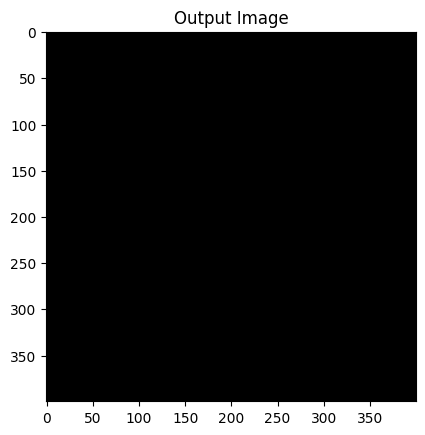

In [20]:
# Load a content image from the local directory
content_img = load_image("/content/Female-portrait-picture-enhanced-with-better-clarity-and-higher-quality-using-Fotors-free-online-AI-photo-enhancer.jpg")

# Load a style image from the WikiArt dataset
style_img = load_image("/content/wikiart-faces/artfaces/abstract-expressionism/0.1270_john-f-kennedy-1963-1.jpg!Blog.jpg", shape=content_img.shape[-2:])
input_img = content_img.clone()

output = run_style_transfer(cnn, content_img, style_img, input_img)
imshow(output, title="Output Image")
